In [ ]:
import pandas as pd  # for data manipulation
import numpy as np  # for numerical calculations
import matplotlib.pyplot as plt  # for data visualizations
import os  # for operating system interactions

# Disable OneDNN optimizations
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

import tensorflow as tf  # for deep learning
from tensorflow.keras.models import Sequential  # for creating sequential models
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization, Dropout, Bidirectional  # for LSTM and other layers
from tensorflow.keras.optimizers import AdamW  # for AdamW optimizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler  # for feature scaling
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau  # for callbacks during training
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error  # for model evaluation
from sqlalchemy import create_engine  # for interacting with databases
from urllib.parse import quote  # for URL encoding
import seaborn as sns  # for data visualization



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_excel(r'/content/drive/MyDrive/Copy of ele_price_forecast_preprocessed_LSTM.xlsx')

In [ ]:
# Ensure 'Datetime' column is in the correct format
df['Datetime'] = pd.to_datetime(df['Datetime'])  # Convert 'Datetime' column to datetime format

df.sort_values('Datetime', inplace=True)  # Sort data by 'Datetime'
df.head()  # Display the first few rows of the DataFrame


,Datetime,Purchase Bid,Sell Bid,Final Scheduled Volume,MCP
0,2023-01-01 00:00:00,1754.7,5189.7,1472.45,2500.38
1,2023-01-01 00:15:00,1734.7,4315.7,1308.57,2650.55
2,2023-01-01 00:30:00,1990.5,3862.2,1483.70,2691.84
3,2023-01-01 00:45:00,1770.5,4025.2,1480.78,2450.92
4,2023-01-01 01:00:00,1843.9,4737.6,1547.89,2450.71


In [ ]:
# Creating lag features
lag = 96  # Number of lag features
for i in range(1, lag + 1):
    df[f'MCP_lag_{i}'] = df['MCP'].shift(i)  # Create lag features for 'MCP'
df.dropna(inplace=True)  # Drop rows with NaN values

df.info()  # Display information about the DataFrame after creating lag features
df.isnull().sum()  # Check for any remaining null values
df.head(15) # Display the first 15 rows of the DataFrame


<class 'pandas.core.frame.DataFrame'>
Index: 75604 entries, 96 to 75699
Columns: 101 entries, Datetime to MCP_lag_96
dtypes: datetime64[ns](1), float64(100)
memory usage: 58.8 MB


,Datetime,Purchase Bid,Sell Bid,Final Scheduled Volume,MCP,MCP_lag_1,MCP_lag_2,MCP_lag_3,MCP_lag_4,MCP_lag_5,...,MCP_lag_87,MCP_lag_88,MCP_lag_89,MCP_lag_90,MCP_lag_91,MCP_lag_92,MCP_lag_93,MCP_lag_94,MCP_lag_95,MCP_lag_96
96,2023-01-02 00:00:00,2141.5,5655.5,1619.45,2450.05,2650.89,3000.75,2810.70,2994.68,3500.75,...,2600.03,2650.52,2650.67,2450.68,2450.38,2450.71,2450.92,2691.84,2650.55,2500.38
97,2023-01-02 00:15:00,2036.4,5641.6,1787.27,2300.50,2450.05,2650.89,3000.75,2810.70,2994.68,...,2650.86,2600.03,2650.52,2650.67,2450.68,2450.38,2450.71,2450.92,2691.84,2650.55
98,2023-01-02 00:30:00,1852.6,5046.3,1561.32,2180.23,2300.50,2450.05,2650.89,3000.75,2810.70,...,2450.44,2650.86,2600.03,2650.52,2650.67,2450.68,2450.38,2450.71,2450.92,2691.84
99,2023-01-02 00:45:00,1826.3,4734.2,1463.89,2400.30,2180.23,2300.50,2450.05,2650.89,3000.75,...,2450.54,2450.44,2650.86,2600.03,2650.52,2650.67,2450.68,2450.38,2450.71,2450.92
100,2023-01-02 01:00:00,1761.3,4856.6,1269.93,2400.95,2400.30,2180.23,2300.50,2450.05,2650.89,...,2450.34,2450.54,2450.44,2650.86,2600.03,2650.52,2650.67,2450.68,2450.38,2450.71
101,2023-01-02 01:15:00,1807.3,4938.9,1360.91,2400.72,2400.95,2400.30,2180.23,2300.50,2450.05,...,2450.32,2450.34,2450.54,2450.44,2650.86,2600.03,2650.52,2650.67,2450.68,2450.38
102,2023-01-02 01:30:00,1358.0,5383.3,1358.00,999.13,2400.72,2400.95,2400.30,2180.23,2300.50,...,2450.30,2450.32,2450.34,2450.54,2450.44,2650.86,2600.03,2650.52,2650.67,2450.68
103,2023-01-02 01:45:00,1409.0,5455.5,1409.00,999.40,999.13,2400.72,2400.95,2400.30,2180.23,...,2768.73,2450.30,2450.32,2450.34,2450.54,2450.44,2650.86,2600.03,2650.52,2650.67
104,2023-01-02 02:00:00,1777.9,5476.1,1650.40,1710.95,999.40,999.13,2400.72,2400.95,2400.30,...,3500.89,2768.73,2450.30,2450.32,2450.34,2450.54,2450.44,2650.86,2600.03,2650.52
105,2023-01-02 02:15:00,1782.8,5476.1,1665.10,1710.38,1710.95,999.40,999.13,2400.72,2400.95,...,3501.84,3500.89,2768.73,2450.30,2450.32,2450.34,2450.54,2450.44,2650.86,2600.03


In [ ]:
# Train-Test Split by Date
split_index = max(0, df.shape[0] - 5526)  # Ensure valid index
split_date = df['Datetime'].iloc[split_index]


In [ ]:
scaler_target = RobustScaler()
df['MCP'] = scaler_target.fit_transform(df[['MCP']])

Train = df[df['Datetime'] < split_date]
Test = df[df['Datetime'] >= split_date]


In [ ]:
# Normalize features using RobustScaler
scaler = RobustScaler()
Train_scaled = scaler.fit_transform(Train.drop(columns=['MCP', 'Datetime']))
Test_scaled = scaler.transform(Test.drop(columns=['MCP', 'Datetime']))
labels_scaled_train = Train[['MCP']].values
labels_scaled_test = Test[['MCP']].values

# Prepare data for LSTM
X_train, y_train = np.array(Train_scaled), np.array(labels_scaled_train)
X_test, y_test = np.array(Test_scaled), np.array(labels_scaled_test)

# Reshape input for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [ ]:
# Build LSTM model
model = Sequential([
    LSTM(150, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], 1)),
    BatchNormalization(),
    LSTM(100, activation='tanh', return_sequences=True),
    LSTM(50, activation='tanh'),
    Dense(1)
])


optimizer = AdamW(learning_rate=0.01, clipnorm=1.0)  # Increase LR from 0.001 to 0.01

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)
model.compile(optimizer=optimizer, loss='mse')
history = model.fit(X_train, y_train, epochs=25, batch_size=128, validation_data=(X_test, y_test),
                    verbose=1, callbacks=[reduce_lr])



Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


548/548 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - loss: 0.4716 - val_loss: 0.1021 - learning_rate: 0.0100
Epoch 2/25
548/548 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - loss: 0.0495 - val_loss: 0.0685 - learning_rate: 0.0100
Epoch 3/25
548/548 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - loss: 0.0438 - val_loss: 0.0412 - learning_rate: 0.0100
Epoch 4/25
548/548 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.0417 - val_loss: 0.0318 - learning_rate: 0.0100
Epoch 5/25
548/548 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.0393 - val_loss: 0.0376 - learning_rate: 0.0100
Epoch 6/25
548/548 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - loss: 0.0586 - val_loss: 0.0316 - learning_rate: 0.0100
Epoch 7/25
548/548 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - loss: 0.0402 - val_loss: 0.0396 - learning_rate: 0.0100
Epoch 8/25
548/548 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 0.0378 - val_loss: 0.0369 - learning_rate: 0.0100
Epoch 9/25
548/548 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 0.0364 - val_loss: 0.0299 - learning_rate: 0.0100
Epo

In [ ]:

# Make predictions
y_pred = model.predict(X_test)

# Inverse transform predictions and actual values
y_test_inv = scaler_target.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler_target.inverse_transform(y_pred)

# Evaluate model
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv) * 100
print(f'RMSE: {rmse}, MAPE: {mape:.2f}%')


173/173 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
RMSE: 361.3106648749417, MAPE: 4.96%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━

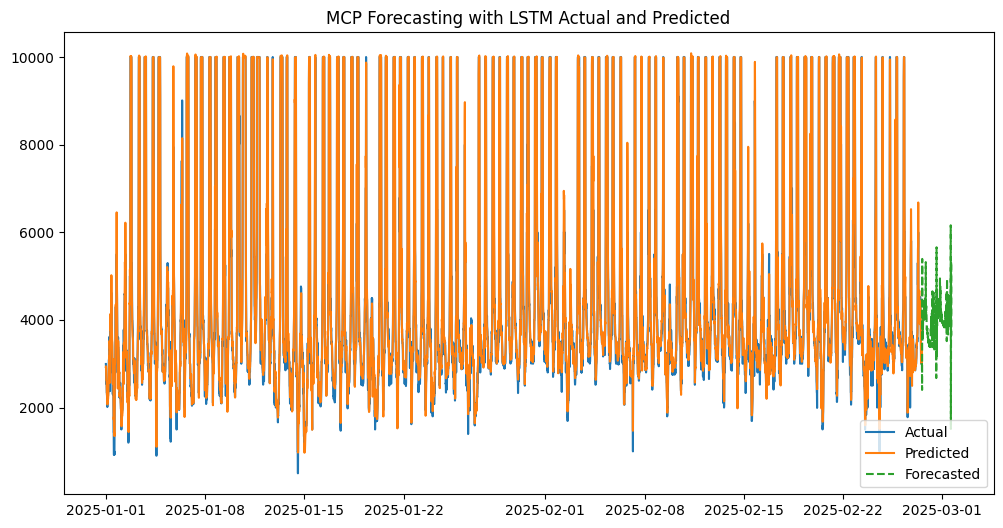

In [ ]:
# Forecast next 200 values
future_predictions = []
future_dates = [Test['Datetime'].iloc[-1] + pd.Timedelta(minutes=15 * i) for i in range(1, 201)]
last_input = X_test[-1].reshape(1, X_test.shape[1], 1)

for _ in range(200):
    pred = model.predict(last_input)
    future_predictions.append(pred[0, 0])
    last_input = np.roll(last_input, -1)
    last_input[0, -1, 0] = pred[0, 0]

# Inverse transform forecasted values
future_predictions_inv = scaler_target.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Calculate 95% confidence interval
std_dev = np.std(y_pred_inv - y_test_inv)
ci_upper = y_pred_inv.flatten() + 1.96 * std_dev
ci_lower = y_pred_inv.flatten() - 1.96 * std_dev

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(Test['Datetime'].values, y_test_inv, label='Actual')
plt.plot(Test['Datetime'].values, y_pred_inv, label='Predicted')
plt.plot(future_dates, future_predictions_inv, label='Forecasted', linestyle='dashed')
plt.legend()
plt.title('MCP Forecasting with LSTM Actual and Predicted')
plt.show()

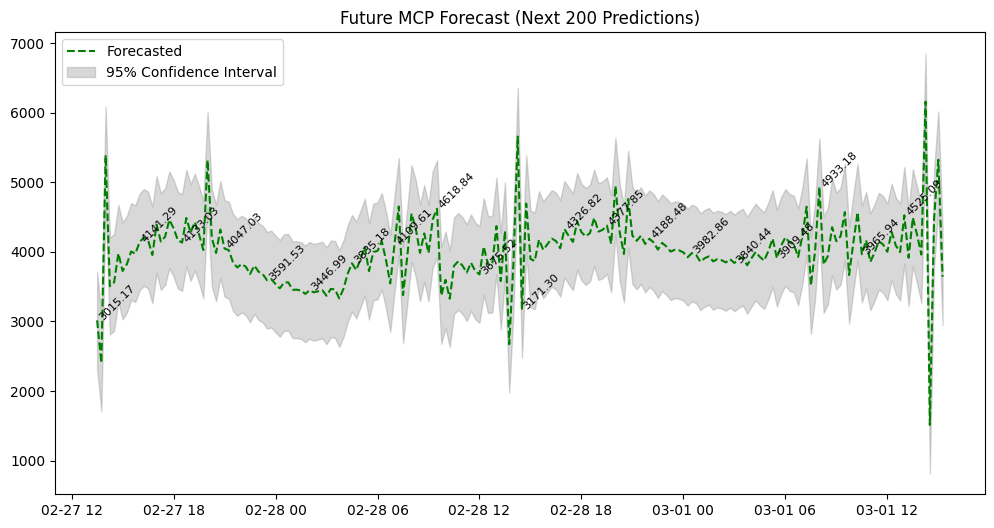

In [ ]:
# Forecasting only plot
plt.figure(figsize=(12, 6))
plt.plot(future_dates, future_predictions_inv, label='Forecasted', linestyle='dashed', color='green')
plt.fill_between(future_dates, future_predictions_inv.flatten() - 1.96 * std_dev,
                 future_predictions_inv.flatten() + 1.96 * std_dev, color='gray', alpha=0.3, label='95% Confidence Interval')
for i in range(0, len(future_dates), 10):
    plt.text(future_dates[i], future_predictions_inv[i], f'{future_predictions_inv[i][0]:.2f}', fontsize=8, rotation=45)
plt.legend()
plt.title('Future MCP Forecast (Next 200 Predictions)')
plt.show()

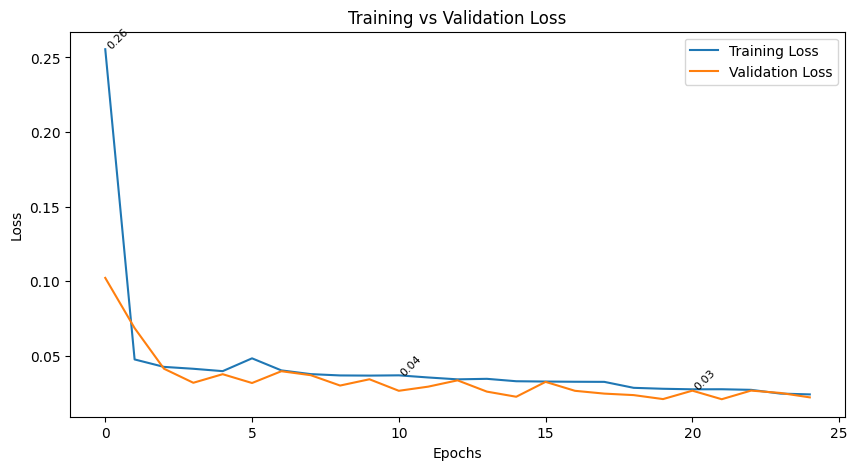

In [ ]:

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
for i in range(0, len(history.history['loss']), 10):
    plt.text(i, history.history['loss'][i], f'{history.history["loss"][i]:.2f}', fontsize=8, rotation=45)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()


2190/2190 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step


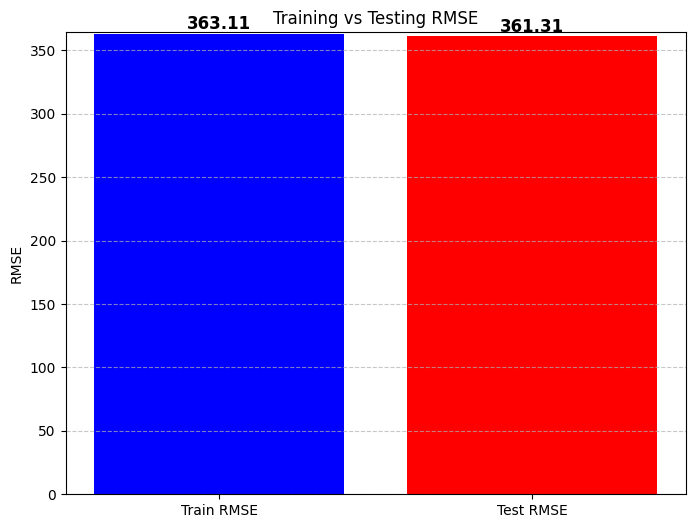

In [ ]:
# Plot RMSE comparison
train_pred = model.predict(X_train)
train_pred_inv = scaler_target.inverse_transform(train_pred)
y_train_inv = scaler_target.inverse_transform(y_train)

train_rmse = np.sqrt(mean_squared_error(y_train_inv, train_pred_inv))
test_rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))

# Plot RMSE comparison
plt.figure(figsize=(8, 6))
bar_colors = ['blue', 'red']
rmse_values = [train_rmse, test_rmse]
labels = ['Train RMSE', 'Test RMSE']

bars = plt.bar(labels, rmse_values, color=bar_colors)

# Annotate values on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, f'{yval:.2f}',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

# Enhance plot readability
plt.ylabel('RMSE')
plt.title('Training vs Testing RMSE')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, max(rmse_values) + 1)  # Adjust y-limit for spacing
plt.show()


In [ ]:
model.save('LSTM with combo_cols.h5')
print('model saved successfully.....')

model saved successfully.....


In [ ]:
# Assuming 'Test' DataFrame contains your test data and 'Datetime' is the datetime column
future_dates = [Test['Datetime'].iloc[-1] + pd.Timedelta(minutes=15 * i) for i in range(1, 201)]
# This creates 200 future dates with 15-minute intervals

# Calculate the confidence interval for the forecasted values
std_dev = np.std(future_predictions_inv) # Calculate std_dev for forecasted values
ci_upper_forecast = future_predictions_inv.flatten() + 1.96 * std_dev
ci_lower_forecast = future_predictions_inv.flatten() - 1.96 * std_dev


forecast_df = pd.DataFrame({
    'Datetime': future_dates,
    'Forecast': future_predictions_inv.flatten(),  # Flatten the array if needed
    'CI_Lower': ci_lower_forecast,  # Use forecasted confidence interval
    'CI_Upper': ci_upper_forecast  # Use forecasted confidence interval
})
print(forecast_df)

               Datetime     Forecast     CI_Lower     CI_Upper
0   2025-02-27 13:30:00  3015.174316  2087.282227  3943.066406
1   2025-02-27 13:45:00  2402.188477  1474.296265  3330.080566
2   2025-02-27 14:00:00  5391.723145  4463.831055  6319.615234
3   2025-02-27 14:15:00  3506.761475  2578.869141  4434.653809
4   2025-02-27 14:30:00  3561.466309  2633.574219  4489.358398
..                  ...          ...          ...          ...
195 2025-03-01 14:15:00  6159.721191  5231.829102  7087.613281
196 2025-03-01 14:30:00  1511.860474   583.968262  2439.752686
197 2025-03-01 14:45:00  4476.304688  3548.412598  5404.196777
198 2025-03-01 15:00:00  5324.705566  4396.813477  6252.597656
199 2025-03-01 15:15:00  3642.164062  2714.271973  4570.056152

[200 rows x 4 columns]
